In [1]:
import os

# Select the backend before importing folps.py
os.environ["FOLPS_BACKEND"] = "numpy"  #'numpy' or 'jax'

from folps_newtest import *
from cosmo_class import *
from use_fkpt import *

✅ Using NumPy with CPU.


In [2]:
#omega_i = Omega_i h² 
omega_b = 0.022;        #baryons
omega_cdm = 0.122;       #CDM
omega_ncdm = 0.0006442;    #massive neutrinos 
h = 0.6711;                 #h = H0/100
z_pk = 0.3;  #evaluation redshift
z_pk_scale = 0.97
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [3]:
%%time
#linear power spectrum
ps = generate_ps(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
            As = 2e-9, ns = 0.965, z = z_pk, z_scale=[0.97],
            N_ur = 2.0328,
            khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'cb')
inputpkT = np.array([ps['kh'], ps['pk']])
kwargs = {'z': z_pk, 'h': h, 'Omega_m': ps['cosmo'].Omega0_m(), 'f0':0.6900011469771554,
          'fnu':ps['cosmo'].Omega_nu/ps['cosmo'].Omega0_m()}

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 229 ms


In [4]:
kwargs

{'z': 0.3,
 'h': 0.6711,
 'Omega_m': 0.3211636237981114,
 'f0': 0.6900011469771554,
 'fnu': 0.004453689063655854}

In [5]:
matrix = MatrixCalculator(A_full=True)
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_AfullTrue.npy


In [6]:
%%time
#1-loop
nonlinear = NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='eds',
                                             **kwargs)

CPU times: user 197 µs, sys: 7 µs, total: 204 µs
Wall time: 199 µs


In [7]:
kwargs

{'z': 0.3,
 'h': 0.6711,
 'Omega_m': 0.3211636237981114,
 'f0': 0.6900011469771554,
 'fnu': 0.004453689063655854}

In [8]:
%%time
table, table_now = nonlinear.calculate_loop_table(k=inputpkT[0], pklin=inputpkT[1], #cosmo=ps['cosmo'],
                                             **kwargs)

CPU times: user 109 ms, sys: 16.1 ms, total: 125 ms
Wall time: 93.2 ms


In [9]:
table[2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [10]:
PshotP = 1. / 0.0002118763
# Bias parameters
b1 = 1.645
b2 = -0.46
bs2 = -4./7*(b1 - 1)
b3nl = 32./315*(b1 - 1)
# EFT parameters
alpha0 = 3                 #units: [Mpc/h]^2
alpha2 = -28.9             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
alphashot0 = 0.08
alphashot2 = -8.1          #units: [Mpc/h]^2
pars = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]
qpar, qper = 1., 1.


k = np.logspace(np.log10(0.01), np.log10(0.3), num=100) # array of  output k in [h/Mpc]

In [11]:
%%time
multipoles = RSDMultipolesPowerSpectrumCalculator(model='EFT')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [12]:
%%time
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars, table=table, table_now=table_now,
                                      bias_scheme='classpt')

CPU times: user 3.65 ms, sys: 125 µs, total: 3.78 ms
Wall time: 3.72 ms


In [13]:
%%time
P0_noir, P2_noir  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars, table=table, table_now=table_now, ells=(0, 2),IR_resummation=False, 
                                             bias_scheme="classpt")

CPU times: user 5.36 ms, sys: 13 µs, total: 5.37 ms
Wall time: 4.81 ms


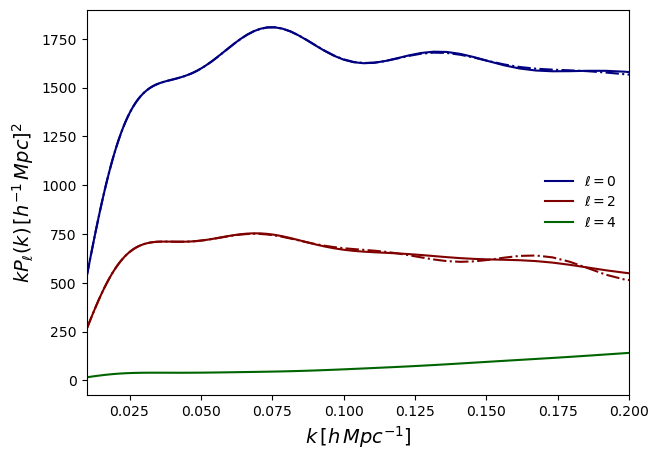

In [14]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k, k * P0, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, k * P0_noir, color = 'navy', ls='-.')

axs.plot(k, k * P2, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, k * P2_noir, color = 'maroon', ls='-.')
axs.plot(k, k * P4, color = 'darkgreen', ls='-', label=r'$\ell = 4$')

axs.set_xlim([k[0], 0.2])
#axs.set_ylim([-200.0, 1800])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [15]:
multipoles.model

'EFT'

In [16]:
len(table)

34

In [17]:
table_now[32]

23.779593993872098

In [18]:
table_now[33]

22.51886909641285

In [19]:
table_now[34]

5.4038558153643805

In [20]:
table_now[35]

0.6900011469771554

In [21]:
np.array([P0, P2, P4])

array([[53224.01011037, 53950.92319635, 54649.77945594, 55317.96699185,
        55952.38144089, 56549.73328663, 57106.8100836 , 57620.59148389,
        58088.32433449, 58507.12323769, 58873.74608469, 59184.30575888,
        59435.37058454, 59624.2139041 , 59747.93276331, 59803.79631368,
        59789.23059961, 59700.94782293, 59536.35501607, 59294.12938996,
        58972.58293324, 58570.14940456, 58085.77776953, 57519.22812838,
        56871.33663533, 56144.08932151, 55339.48555858, 54459.66884611,
        53507.07684282, 52485.48277021, 51400.79566866, 50261.60671903,
        49076.122092  , 47852.31635831, 46598.17865444, 45320.93138755,
        44028.8823809 , 42734.33853552, 41449.72157572, 40186.83165172,
        38956.33468215, 37766.84493904, 36625.27404609, 35538.07963409,
        34510.90216795, 33548.60199154, 32655.60039288, 31831.77774384,
        31072.20442461, 30371.64341841, 29722.16701668, 29112.30313256,
        28528.24993676, 27954.25642578, 27373.16671717, 26768.05

In [ ]:
############################# Bispectrum ###############################3

In [ ]:
classy  = run_class(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
                    As = 2e-9, ns = 0.965, z = 0.3, z_scale=[0.97],
                    N_ur = 2.0328,
                    khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')

In [ ]:
#pars for Bispectrum
z_pk=0.0;


b1v = 1;
c1v = 0; b2v = 0.0; bsv = 0;

Omv=classy['cosmo'].Omega0_m();
hv=classy['cosmo'].h(); 
f=classy['cosmo'].scale_independent_growth_factor_f(z_pk)

qparv = 1; qperpv = 1;
Bshotv=0.0
Pshotv=0.0


bisp_nuis_paramsv=[b1v,b2v,bsv,c1v,Bshotv,Pshotv]
bisp_cosmo_paramsv=[Omv, hv, nonlinear.f0]

In [ ]:
ks = np.logspace(np.log10(0.0001), np.log10(0.4), 30)
k1k2T = np.vstack([ks,ks]).T

In [ ]:
%%time
#precision=[8,10,10]
B000,B202=Bisp_Sugiyama(bisp_cosmo_paramsv, bisp_nuis_paramsv, pk_input=nonlinear.inputpkT, z_pk=z_pk, k1k2pairs=k1k2T, Omfid=-1,qpar=1,qperp=1)#,precision=precision)

In [ ]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) $', fontsize =  14)

#axs.plot(k1k2T.T[0], k1k2T.T[0]*k1k2T.T[0]*B000, ls='-', label='B000')
#axs.plot(k1k2T.T[0],k1k2T.T[0]*k1k2T.T[0]*B202, ls='-', label='B202')


axs.loglog(k1k2T.T[0],B000, ls='-', label='B000')
axs.loglog(k1k2T.T[0],B202, ls='-', label='B202')
axs.loglog(nonlinear.inputpkT[0],nonlinear.inputpkT[1]*nonlinear.inputpkT[1], ls='-', label='P^2')



axs.set_xlim([0.0001,0.15])
axs.set_ylim([1e5, 1e10])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [ ]:
inputpkT[1]

# 